# Exercise 2: Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw2_123456789_987654321.ipynb` if you submitted in pairs and `hw2_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7f9bc0937790>, <__main__.Node at 0x7f9bc09379d0>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
data.dropna(axis=1, inplace=True)

assert data.isna().sum().sum() == 0, 'There are still NA values in the data'

We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split

# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


In [7]:
y.shape

(8124,)

## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [8]:
def find_p(data):
    """
    finding the proportions of taget value
    """
    return np.unique(data[:, -1], return_counts=True)[1] / data.shape[0]

In [9]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    
    p = find_p(data)
    gini = 1 - (p**2).sum()

    return gini

In [10]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """    
    p = find_p(data)

    entropy = - (p * np.log2(p)).sum()

    return entropy

In [11]:
# test the impurity measures
A = np.array([['a'], ['b'], ['a'], ['a'], ['b'], ['b']])
B = np.array([['a'], ['a'], ['a'], ['a'], ['a'], ['a']])

assert (calc_gini(A) == 0.5) & (calc_entropy(A) == 1) & (calc_gini(B) == 0) & (calc_entropy(B) == 0), 'The functions are not correct -> please check again'

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [12]:
def goodness_of_split(data, feature, impurity_func, gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.
    - gain_ratio: goodness of split or gain ratio flag.

    Returns the goodness of split.
    """
    N = data.shape[0]
    impurity = impurity_func(data)
    gain = 0

    feature_values = np.unique(data[:, feature])

    for value in feature_values:
        value_data = data[data[:, feature] == value]
        n = value_data.shape[0]
        gain += ((n / N) * impurity_func(value_data))

    goodness = impurity - gain

    if gain_ratio:
        probs = np.unique(data[:, feature], return_counts=True)[1] / data.shape[0]
        split_information = -(np.log2(probs) * probs).sum()
        goodness = goodness_of_split(data, feature, calc_entropy) / split_information

    return goodness

## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [13]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic
    functionality as described above. It is highly recommended that you
    first read and understand the entire exercise before diving into this class.
    """

    def __init__(self, feature, value, depth, data, num_samples=0, feature_name=None, parent=None):
        self.feature = feature  # column index of criteria being tested
        self.value = value
        self.depth = depth
        self.data = data
        self.children = []
        self.pred = None
        self.num_samples = num_samples
        self.feature_name = feature_name
        self.parent = parent
        self.target_values = {}  # {'e': 0, 'p': 0}

    def add_child(self, node):
        self.children.append(node)

In [14]:
def build_tree(data, impurity, gain_ratio=False, min_samples_split=1, max_depth=1000):
    """
    Build a tree using the given impurity measure and training dataset.
    You are required to fully grow the tree until all leaves are pure.

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - gain_ratio: goodness of split or gain ratio flag
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None

    data = pd.DataFrame(data)

    root = DecisionNode(None, None, 0, data, data.shape[0], 'ROOT')

    # create a queue to manage the process
    queue = []

    queue.insert(0, root)

    tree_depth = 0

    while len(queue) > 0:
        
        cur_node = queue.pop()

        # update the depth of the tree
        tree_depth = max(cur_node.depth, tree_depth)

        # update the target values' proportions
        labels, counts = np.unique(cur_node.data.iloc[:, -1], return_counts=True)
        cur_node.target_values = dict(zip(labels, counts))

        # set the prediction according to the most frequent value of target
        cur_node.pred = labels[np.argmax(counts)]

        # check that the node's depth is less than the maximum depth
        if cur_node.depth >= max_depth:
            continue
        
        # check that the node is not pure - there is a reason to continue splitting the data
        if np.isclose(impurity(cur_node.data.to_numpy()), 0):
            continue
        
        # check that the number of samples in the node is larger than the minimum value
        if cur_node.num_samples <= min_samples_split:
            continue
        
        # find the feature that achives the maximal goodness of split
        max_goodness_dict = {}
        for idx in range(cur_node.data.iloc[:, :-1].shape[1]):
            max_goodness_dict[idx] = goodness_of_split(cur_node.data.to_numpy(), idx, impurity, gain_ratio)
        max_goodness_idx = max(max_goodness_dict, key=max_goodness_dict.get)

        # verify that the maximal gooness of split is not 0
        if np.isclose(max_goodness_dict[max_goodness_idx], 0):
            continue
        
        # set the node's feature as the maximal goodness feature
        cur_node.feature = cur_node.data.columns[max_goodness_idx]

        # modify the depth of the child of the current node
        node_depth = cur_node.depth + 1

        # create the children of the current node
        for label in np.unique(cur_node.data[cur_node.feature]):

            # set the data of the child node
            node_data = cur_node.data[cur_node.data[cur_node.feature] == label]
            node_data = node_data.drop([cur_node.feature], axis=1)

            # create the child node
            child = DecisionNode(None, label, node_depth, node_data, node_data.shape[0], parent=cur_node)

            # set the child node as actual child of the current node and add it to the queue
            cur_node.add_child(child)
            queue.insert(0, child)
    
    return root

In [15]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [16]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    while len(node.children) > 0:

        best_feature = node.feature
        instance_value = instance[best_feature]
                
        child = [idx for idx in range(len(node.children)) if node.children[idx].value == instance_value]
        
        try:
            node = node.children[child[0]]
        except IndexError:
            return node.pred
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return node.pred

In [17]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    target_values = dataset[:, -1]
    predictions = np.array([predict(node, instance) for instance in dataset])
    accuracy = (target_values == predictions).sum() / dataset.shape[0] * 100
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [18]:
tree_gini_accuracy_train, tree_gini_accuracy_test = calc_accuracy(tree_gini, X_train) , calc_accuracy(tree_gini, X_test)
tree_entropy_accuracy_train, tree_entropy_accuracy_test = calc_accuracy(tree_entropy, X_train), calc_accuracy(tree_entropy, X_test)
tree_gain_ratio_accuracy_train, tree_gain_ratio_accuracy_test = calc_accuracy(tree_entropy_gain_ratio, X_train), calc_accuracy(tree_entropy_gain_ratio, X_test)

print(f"{'-'*80}\ngini on training set achieved {tree_gini_accuracy_train:.3f}% accuracy\ngini on test set achieved {tree_gini_accuracy_test:.3f}% accuracy")
print(f"{'-'*80}\nentropy on training set achieved {tree_entropy_accuracy_train:.3f}% accuracy\nentropy on test set achieved {tree_entropy_accuracy_test:.3f}% accuracy")
print(f"{'-'*80}\ngain ratio on training set achieved {tree_gain_ratio_accuracy_train:.3f}% accuracy\ngain ratio on test set achieved {tree_gain_ratio_accuracy_test:.3f}% accuracy")

best_test_accuracy_dict = {tree_gini_accuracy_test: (calc_gini, False), tree_entropy_accuracy_test: (calc_entropy, False), tree_gain_ratio_accuracy_test: (calc_entropy, True)}
best_test_accuracy = best_test_accuracy_dict[max(best_test_accuracy_dict)]

--------------------------------------------------------------------------------
gini on training set achieved 99.245% accuracy
gini on test set achieved 77.499% accuracy
--------------------------------------------------------------------------------
entropy on training set achieved 99.409% accuracy
entropy on test set achieved 77.253% accuracy
--------------------------------------------------------------------------------
gain ratio on training set achieved 99.639% accuracy
gain ratio on test set achieved 78.484% accuracy


## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.


best result is achieved when the max_depth is 4 with 89.51% accuracy



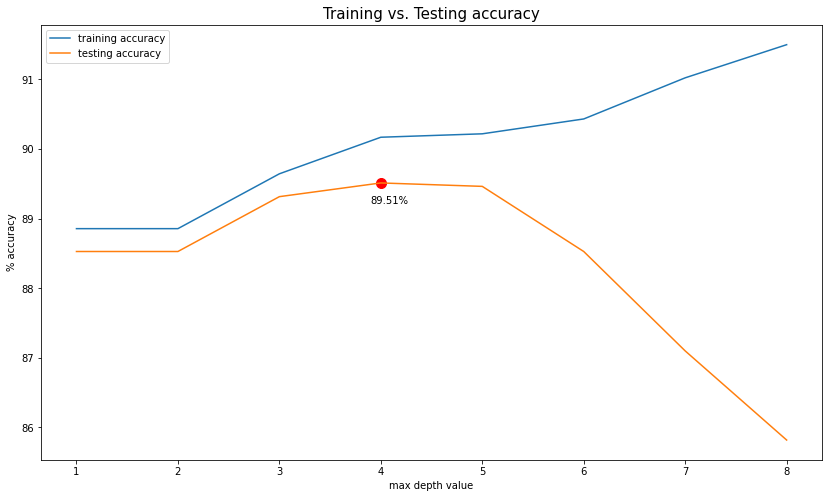

In [19]:
max_depth_values = np.arange(1,9)
training_accuracy = {}
testing_accurcay = {}

for max_depth_value in max_depth_values:
    max_depth_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], max_depth=max_depth_value)
    training_accuracy[max_depth_value] = calc_accuracy(max_depth_tree, X_train)
    testing_accurcay[max_depth_value] = calc_accuracy(max_depth_tree, X_test)

max_res_idx_max_depth = max(testing_accurcay, key=testing_accurcay.get)
print(f"\nbest result is achieved when the max_depth is {max_res_idx_max_depth} with {testing_accurcay[max_res_idx_max_depth]:.2f}% accuracy\n")

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.plot(training_accuracy.keys(), training_accuracy.values(), label='training accuracy')
axes.plot(testing_accurcay.keys(), testing_accurcay.values(), label='testing accuracy')
axes.set_title("Training vs. Testing accuracy", fontsize=15)
axes.set_xlabel("max depth value", fontsize=10)
axes.set_ylabel(f"{'%'} accuracy", fontsize=10)
axes.scatter(max_res_idx_max_depth, testing_accurcay[max_res_idx_max_depth], 100, 'r')
axes.text(max_res_idx_max_depth-0.1, testing_accurcay[max_res_idx_max_depth]-0.3, s=f'{testing_accurcay[max_res_idx_max_depth]:.2f}%')
axes.legend()

## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)


best result is achieved when the min_sample_split is 50 with 89.51% accuracy



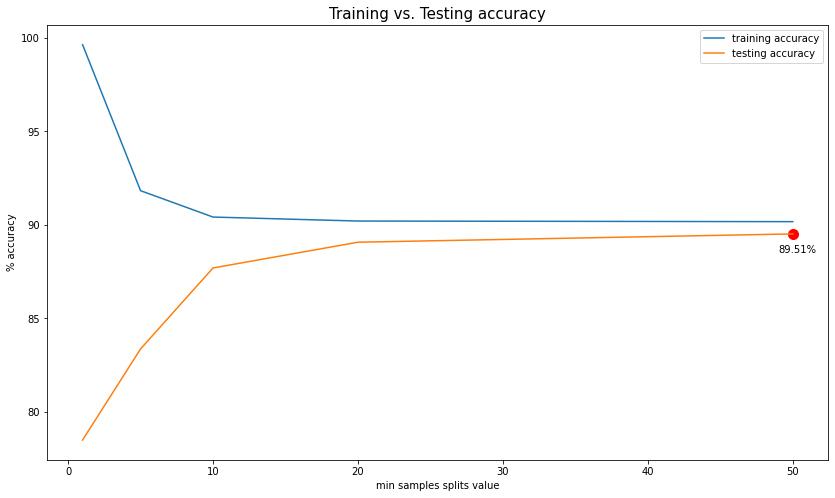

In [20]:
min_sample_split_values = [1, 5, 10, 20, 50]
training_accuracy = {}
testing_accurcay = {}

for min_split_value in min_sample_split_values:
    min_split_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], min_samples_split=min_split_value)
    training_accuracy[min_split_value] = calc_accuracy(min_split_tree, X_train)
    testing_accurcay[min_split_value] = calc_accuracy(min_split_tree, X_test)

max_res_idx_min_sample = max(testing_accurcay, key=testing_accurcay.get)
print(f"\nbest result is achieved when the min_sample_split is {max_res_idx_min_sample} with {testing_accurcay[max_res_idx_min_sample]:.2f}% accuracy\n")

fig, axes = plt.subplots(1, 1, figsize=(14, 8))
axes.plot(training_accuracy.keys(), training_accuracy.values(), label='training accuracy')
axes.plot(testing_accurcay.keys(), testing_accurcay.values(), label='testing accuracy')
axes.set_title("Training vs. Testing accuracy", fontsize=15)
axes.set_xlabel("min samples splits value", fontsize=10)
axes.set_ylabel(f"{'%'} accuracy", fontsize=10)
axes.scatter(max_res_idx_min_sample, testing_accurcay[max_res_idx_min_sample], 100, 'r')
axes.text(max_res_idx_min_sample-1, testing_accurcay[max_res_idx_min_sample]-1, s=f'{testing_accurcay[max_res_idx_min_sample]:.2f}%')
axes.legend()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [21]:
#### Your code here ####
tree_max_depth = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], max_depth=max_res_idx_max_depth)
tree_min_samples_split = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], min_samples_split=max_res_idx_min_sample)

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [22]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    total_nodes = 1
    for child in node.children:
        total_nodes += count_nodes(child)
    return total_nodes
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    

print(f"total nodes in tree_gini -> {count_nodes(tree_gini)}\ntotal nodes in tree_entropy -> {count_nodes(tree_entropy)}\ntotal nodes in tree_entropy_gain_ratio -> {count_nodes(tree_entropy_gain_ratio)}")
print(f"\n{'*' * 50}\n")
print(f"total nodes in tree_max depth -> {count_nodes(tree_max_depth)}\ntotal nodes in tree_min_samples_split -> {count_nodes(tree_min_samples_split)}")

total nodes in tree_gini -> 3231
total nodes in tree_entropy -> 3227
total nodes in tree_entropy_gain_ratio -> 4928

**************************************************

total nodes in tree_max depth -> 194
total nodes in tree_min_samples_split -> 350


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [23]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    if len(node.children) == 0:

        print(f"{'    ' * node.depth}[X{parent_feature}={feature_val}, leaf]: [{node.target_values}]")
    
    else:
        feature_name = 'ROOT' if node.feature_name == 'ROOT' else f'X{parent_feature}={feature_val}'
        print(f"{'    ' * node.depth}[{feature_name}, feature=X{node.feature}]")

    for child in node.children:
        print_tree(child, parent_feature=node.feature, feature_val=child.value)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [24]:
results = {}

min_sample_split_values = [1, 5, 10, 20, 50]
training_accuracy = {}
testing_accurcay = {}

for min_split_value in min_sample_split_values:
    min_split_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], min_samples_split=min_split_value)
    print(f"total nodes in {min_split_value=} -> {count_nodes(min_split_tree)}")
    if count_nodes(min_split_tree) < 50:
        training_accuracy[min_split_value] = calc_accuracy(min_split_tree, X_train)
        testing_accurcay[min_split_value] = calc_accuracy(min_split_tree, X_test)

if testing_accurcay:
    max_res_idx_min_sample = max(testing_accurcay, key=testing_accurcay.get)
    print(f"\nbest result is achieved when the min_sample_split is {max_res_idx_min_sample} with {testing_accurcay[max_res_idx_min_sample]:.2f}% accuracy\n")
    results['tree_min_samples_split'] = (max_res_idx_min_sample, testing_accurcay[max_res_idx_min_sample])
else:
    print(f"\nThere are no tree with less than 50 nodes using {min_sample_split_values=}")
    results['tree_min_samples_split'] = (0, 0)

print(f"\n{'*' * 100}\n")

max_depth_values = np.arange(1,9)
training_accuracy = {}
testing_accurcay = {}

for max_depth_value in max_depth_values:
    max_depth_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], max_depth=max_depth_value)
    print((f"total nodes in {max_depth_value=} -> {count_nodes(max_depth_tree)}"))
    if count_nodes(max_depth_tree) < 50:
        training_accuracy[max_depth_value] = calc_accuracy(max_depth_tree, X_train)
        testing_accurcay[max_depth_value] = calc_accuracy(max_depth_tree, X_test)

if testing_accurcay:
    max_res_idx_max_depth = max(testing_accurcay, key=testing_accurcay.get)
    print(f"\nbest result is achieved when the max_depth is {max_res_idx_max_depth} with {testing_accurcay[max_res_idx_max_depth]:.2f}% accuracy\n")
    results['max_depth_value'] = (max_res_idx_max_depth, testing_accurcay[max_res_idx_max_depth])

else:
    print(f"\nThere are no tree with less than 50 nodes using {max_depth_values=}")
    results['max_depth_value'] = (0, 0)

print(f"{'*' * 100}\n")

if sum([value[1] for value in results.values()]) > 0:
    print(f"best accuracy of tree with less than 50 nodes is {results[max(results, key=results.get)][1]:.2f}% -> it is achived in {max(results, key=results.get)} tree where the value is {results[max(results, key=results.get)][0]}")
else:
    print(f"there is no tree with less than 50 nodes with the current arguments")

total nodes in min_split_value=1 -> 4928
total nodes in min_split_value=5 -> 2120
total nodes in min_split_value=10 -> 1280
total nodes in min_split_value=20 -> 742
total nodes in min_split_value=50 -> 350

There are no tree with less than 50 nodes using min_sample_split_values=[1, 5, 10, 20, 50]

****************************************************************************************************

total nodes in max_depth_value=1 -> 10
total nodes in max_depth_value=2 -> 31
total nodes in max_depth_value=3 -> 77
total nodes in max_depth_value=4 -> 194
total nodes in max_depth_value=5 -> 390
total nodes in max_depth_value=6 -> 698
total nodes in max_depth_value=7 -> 1062
total nodes in max_depth_value=8 -> 1485

best result is achieved when the max_depth is 1 with 88.53% accuracy

****************************************************************************************************

best accuracy of tree with less than 50 nodes is 88.53% -> it is achived in max_depth_value tree where the 

In [25]:
#### Your code here ####
if max(results, key=results.get) == 'max_depth_value':
    best_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], max_depth=results[max(results, key=results.get)][0])
elif max(results, key=results.get) == 'tree_min_samples_split':
    best_tree = build_tree(X_train, best_test_accuracy[0], best_test_accuracy[1], min_samples_split=results[max(results, key=results.get)][0])
else:
    raise Exception('No such tree found!')

In [26]:
print_tree(best_tree)

[ROOT, feature=X4]
    [X4=a, leaf]: [{'e': 273, 'p': 31}]
    [X4=c, leaf]: [{'e': 10, 'p': 137}]
    [X4=f, leaf]: [{'e': 170, 'p': 1438}]
    [X4=l, leaf]: [{'e': 272, 'p': 27}]
    [X4=m, leaf]: [{'e': 2, 'p': 25}]
    [X4=n, leaf]: [{'e': 2332, 'p': 344}]
    [X4=p, leaf]: [{'e': 8, 'p': 175}]
    [X4=s, leaf]: [{'e': 38, 'p': 380}]
    [X4=y, leaf]: [{'e': 49, 'p': 382}]


In [27]:
# for verification only
print_tree(tree_gini)

[ROOT, feature=X4]
    [X4=a, feature=X2]
        [X2=n, feature=X8]
            [X8=n, feature=X19]
                [X19=s, feature=X0]
                    [X0=f, feature=X18]
                        [X18=k, leaf]: [{'e': 1}]
                        [X18=n, feature=X20]
                            [X20=g, leaf]: [{'e': 1}]
                            [X20=p, leaf]: [{'p': 1}]
                    [X0=x, leaf]: [{'e': 2, 'p': 2}]
                [X19=y, leaf]: [{'e': 8}]
            [X8=p, feature=X0]
                [X0=f, feature=X19]
                    [X19=s, leaf]: [{'e': 2}]
                    [X19=y, leaf]: [{'p': 1}]
                [X0=x, leaf]: [{'e': 7}]
            [X8=w, feature=X18]
                [X18=k, feature=X0]
                    [X0=f, leaf]: [{'e': 3}]
                    [X0=x, feature=X20]
                        [X20=g, leaf]: [{'p': 1}]
                        [X20=p, leaf]: [{'e': 2}]
                [X18=n, leaf]: [{'e': 7}]
        [X2=w, feature=X8]
   